In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib

In [2]:
maxent_cv_model = joblib.load('/cluster/home/maikents/maxent_model_pipeline_6.pkl')

In [3]:
X_train = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/pipeline6/X_train.csv")
X_test = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/pipeline6/X_test.csv")
y_train = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/pipeline6/y_train.csv")
y_test = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/pipeline6/y_test.csv")

In [4]:
def jackknife_test(model, X_train, y_train, X_test, y_test):
    n_features = X_train.shape[1]
    
    auc_scores_individual_features = {}
    auc_scores_leave_one_out = {}

    for i in range(n_features):
        X_train_single = X_train.iloc[:, i].values.reshape(-1, 1)
        X_test_single = X_test.iloc[:, i].values.reshape(-1, 1)

        model.fit(X_train_single, y_train)

        y_pred_single = model.predict(X_test_single)
        auc_single = roc_auc_score(y_test, y_pred_single)
        auc_scores_individual_features[X_train.columns[i]] = auc_single
    
    for i in range(n_features):
        X_train_loo = X_train.drop(X_train.columns[i], axis=1)
        X_test_loo = X_test.drop(X_test.columns[i], axis=1)

        model.fit(X_train_loo, y_train)

        y_pred_loo = model.predict(X_test_loo)
        auc_loo = roc_auc_score(y_test, y_pred_loo)
        auc_scores_leave_one_out[X_train.columns[i]] = auc_loo
    
    model.fit(X_train, y_train)
    y_pred_full = model.predict(X_test)
    full_auc = roc_auc_score(y_test, y_pred_full)

    return full_auc, auc_scores_individual_features, auc_scores_leave_one_out


In [5]:
best_model = maxent_cv_model.best_estimator_

full_auc, auc_scores_individual_features, auc_scores_leave_one_out = jackknife_test(best_model, X_train, y_train, X_test, y_test)

print(f"Full AUC score = {full_auc:.3f}")


for feature, auc in auc_scores_leave_one_out.items():
    print(f"{feature} dropped: AUC = {auc:.3f}")


for feature, auc in auc_scores_individual_features.items():
    print(f"{feature} only: AUC = {auc:.3f}")

Full AUC score = 0.933
bathymetry dropped: AUC = 0.932
slope dropped: AUC = 0.937
fine_BPI_std dropped: AUC = 0.931
broad_BPI_std dropped: AUC = 0.933
log_ruggedness dropped: AUC = 0.928
aspect_cos dropped: AUC = 0.926
aspect_sin dropped: AUC = 0.936
temperature_min dropped: AUC = 0.931
temperature_mean dropped: AUC = 0.936
salinity_mean dropped: AUC = 0.934
current_speed_mean dropped: AUC = 0.941
statistical_northness dropped: AUC = 0.935
statistical_eastness dropped: AUC = 0.936
current_aspect_angle dropped: AUC = 0.935
chlor_a_mean dropped: AUC = 0.937
sediment_nitrate_10th_percentile dropped: AUC = 0.932
sediment_silicate_10th_percentile dropped: AUC = 0.933
sediment_silicate_90th_percentile dropped: AUC = 0.928
x_bin dropped: AUC = 0.937
y_bin dropped: AUC = 0.937
bathymetry only: AUC = 0.763
slope only: AUC = 0.706
fine_BPI_std only: AUC = 0.642
broad_BPI_std only: AUC = 0.660
log_ruggedness only: AUC = 0.759
aspect_cos only: AUC = 0.647
aspect_sin only: AUC = 0.527
temperature_m

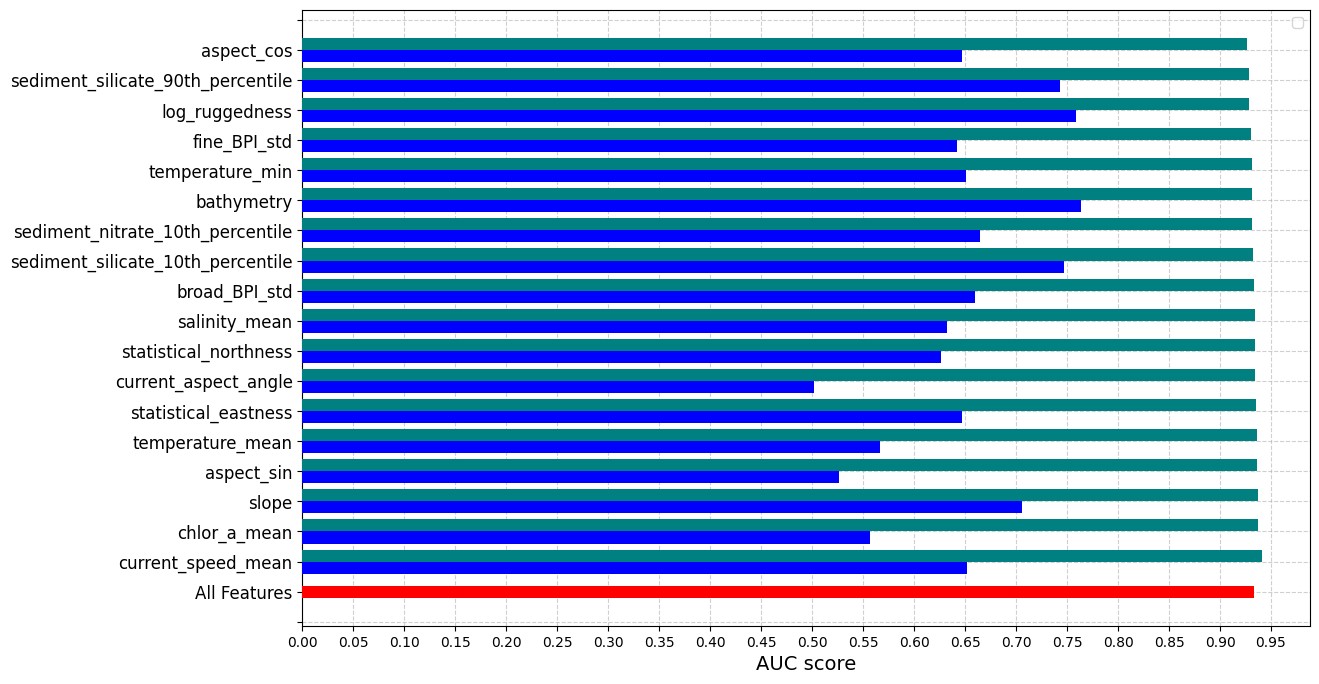

In [7]:
#Jackknife test plot
sorted_features = sorted(auc_scores_leave_one_out.items(), key=lambda x: x[1], reverse=True)
features = [feature for feature, _ in sorted_features]
features_to_remove = ['x_bin', 'y_bin']
features = [f for f in features if f not in features_to_remove]
auc_scores_leave_one_out_sorted = [auc_scores_leave_one_out[feature] for feature in features]
auc_scores_individual_features_sorted = [auc_scores_individual_features[feature] for feature in features]

fig, ax = plt.subplots(figsize=(13, 8))

y_pos = np.arange(len(features) + 1) 

ax.barh(y_pos[0], full_auc, color='red', align='center', height=0.4, zorder=3) 
for i, feature in enumerate(features):
    ax.barh(y_pos[i+1] - 0.2, auc_scores_individual_features_sorted[i], color='blue', align='center', height=0.4, zorder=3)  # Blue bar
    ax.barh(y_pos[i+1] + 0.2, auc_scores_leave_one_out_sorted[i], color='teal', align='center', height=0.4, zorder=3)   # Teal bar


ax.set_xlabel('AUC score', fontsize=14)
#ax.set_title('Jackknife Test using AUC Scores for Individual Features and Full Model')
ax.set_yticks(y_pos)
ax.set_yticklabels(['All Features'] + features, fontsize=12) 
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05)) 
ax.yaxis.set_major_locator(plt.MultipleLocator(1))  
ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())
plt.show()
